# Process the data
This notebook shows a simple example of extracting data at a point on the downloaded xarray from the `load_data.ipynb` file. At the end of that file, I ran `%store ds` where `ds` is the xarray of SST values.

In [6]:
# This is stored from load_data.ipynb file so run that first
%store -r ds

In [7]:
ds

<xarray.Dataset>
Dimensions:           (lat: 720, lon: 1440, time: 1, nv: 2)
Coordinates:
  * lat               (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon               (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time              (time) datetime64[ns] 2016-01-01
Dimensions without coordinates: nv
Data variables:
    lat_bnds          (lat, nv) float32 -90.0 -89.75 -89.75 ... 89.75 89.75 90.0
    lon_bnds          (lon, nv) float32 -180.0 -179.8 -179.8 ... 179.8 180.0
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    id:                         NCEI-L4LRblend-GLOB-AVHRR_OI
    references:                 Reynolds, et al.(2009) What is New in Version...
    institution:                NOAA/NESDIS/NCEI
    creator_name:               NCEI Products and Services
    ...                         ...
    Metadata_Link.:             http://doi.org/10.7289/V5SQ8XB5
    keywords:                   Oceans>Ocean Temperature>Sea Surface Temperature
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   CF Standard Name Table v29
    processing_level:           L4
    cdm_data_type:              Grid

# Get SST at a particular lat/lon value
I have my lat/lon data in a file `data/sample_point_pairs.csv`. These are points along the North and South America coasts. My lat/lon values are not on the same grid as the SST data, so I need to find the "pixel" where my lat/lon value lies. 

In [8]:
import pandas as pd
df = pd.read_csv('../data/sample_point_pairs.csv')

Here is a lat/lon pair.

In [9]:
ns = [df.iloc[0]["lat.ns"], df.iloc[0]["lon.ns"]]
ns

[54.8932363035493, -164.839138084371]

Here is the code to get SST (in Kelvin) at a particular lat/lon point.

In [10]:
ds.analysed_sst.sel(lat=ns[0], lon=ns[1], method="nearest").values[0]

278.32

# Get the SST for all lat/lon pairs

First I will define a function that gets SST at a lat/lon pair.

In [11]:
def getsst(lat, lon):
    sst = ds.analysed_sst.sel(lat=lat, lon=lon, method="nearest").values[0]
    return sst

Now I can apply this get all the SST values for the pairs in my `df` of lat/lon pairs. First the nearshore pairs.

In [12]:
df['sst.ns'] = df.apply(lambda row: getsst(row['lat.ns'], row['lon.ns']), axis=1)

Next the offshore pairs.

In [14]:
df['sst.os'] = df.apply(lambda row: getsst(row['lat.os'], row['lon.os']), axis=1)

Now the difference.

In [15]:
df['sst.diff'] = df.apply(lambda row: row['sst.os'] - row['sst.ns'], axis=1)

Now the upwelling index.

In [16]:
df['up.index'] = df.apply(lambda row: row['sst.diff']>2, axis=1)

Add a location index. Just the index.

In [17]:
df['loc'] = df.index

# Make a plot

In [18]:
# Not sure I need this for pandas plotting
%matplotlib inline

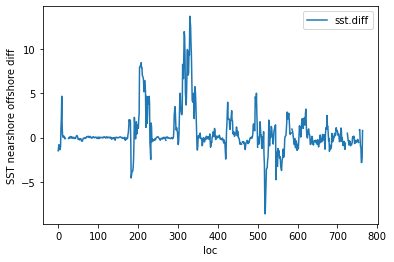

In [19]:
df.plot.line(x='loc',y='sst.diff', ylabel="SST nearshore offshore diff");

Ok that is not a useful plot, but I can see that it worked. Upwelling would be sst.diffFor example, I have no idea where 'loc=300' i

# Make a function to do this
I need to compute the SST diff for each nc file. Because I work in R not Python, I am just doing the data crunching in Python and then I'll port that over to R to work on it. My data sets are not that huge. 800 coastal locations times 30 years times 365 days so about 1Gb of data.

In [20]:
def getsst(ras, lat, lon):
    sst = ras.analysed_sst.sel(lat=lat, lon=lon, method="nearest").values[0]
    return sst
def getdf(ras, pts):
    # takes a SST raster and the pandas pts data frame
    df_new = pts
    df_new['sst.ns'] = df_new.apply(lambda row: getsst(ras, row['lat.ns'], row['lon.ns']), axis=1)
    df_new['sst.os'] = df_new.apply(lambda row: getsst(ras, row['lat.os'], row['lon.os']), axis=1)
    df_new['sst.diff'] = df_new.apply(lambda row: row['sst.os'] - row['sst.ns'], axis=1)
    df_new['loc'] = df_new.index
    return df_new

Let's see how long this takes to run.

In [21]:
%timeit getdf(ds, df)

16.3 s ± 60 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Takes about 16 seconds to run one day. Hmm that will take 2 days to run 30 years worth of data, and I started with 0.25 grid data and just the nearshore/offshore difference so the super easy case. The MUR data is 0.01 grid and I'll be doing an area average not the SST at the point. Hmm... maybe there is a faster way to do this simple calculation.

In [22]:
16*30*365/(60*60)

48.666666666666664

# Alternate approach using indices
From https://github.com/ICESAT-2HackWeek/xarray_open_tutorial/blob/master/xarray_examples.ipynb

In [23]:
import xarray as xr

In [28]:
da = xr.DataArray(df[["lat.ns", "lon.ns"]], dims=['x', 'y'])
da

<xarray.DataArray (x: 764, y: 2)>
array([[  54.8932363 , -164.83913808],
       [  55.20135599, -164.10862178],
       [  55.46378745, -163.28398429],
       ...,
       [ -52.34896977,  -59.46896573],
       [ -52.41472968,  -60.56085741],
       [ -52.56237638,  -61.67186258]])
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 755 756 757 758 759 760 761 762 763
  * y        (y) object 'lat.ns' 'lon.ns'

In [44]:
ind_x = xr.DataArray(df["lon.ns"], dims=['i'])
ind_y = xr.DataArray(df["lat.ns"], dims=['i'])

In [45]:
ds.analysed_sst.sel(lon=ind_x, lat=ind_y, method='nearest').values

array([[278.32   , 278.00998, 277.69998, 278.00998, 278.03   , 277.83   ,
        277.29   , 274.81   , 273.84   , 271.77   , 272.74   , 272.18   ,
        271.94998, 271.85   , 271.66998, 271.61   , 271.77   , 271.69   ,
        271.6    ,       nan,       nan,       nan,       nan,       nan,
              nan,       nan, 271.72998, 271.62   , 271.59   , 271.65   ,
              nan, 271.6    , 271.52   , 271.56   , 271.46   , 271.50998,
        271.49   , 271.57   , 271.53   , 271.49   , 271.54   , 271.57   ,
        271.59   , 271.6    , 271.55   , 271.41998, 271.35   , 271.35   ,
        271.38   , 271.35   , 271.54   , 271.54   , 271.50998, 271.68   ,
        271.63   , 271.66998, 271.72   , 271.78   , 272.03   , 272.06   ,
        272.09   , 272.06   , 271.87   , 271.75   , 271.72   , 271.74   ,
        271.69998, 271.69998, 271.66998, 271.65   , 271.58   , 271.57   ,
        271.59   , 271.58   , 271.63   , 271.56   , 271.52   , 271.55   ,
        271.58   , 271.58   , 271.59  

In [43]:
lat = [85.,86.,87.]
lon = [0.,5.,10.]
ind_x = xr.DataArray(lon, dims=['i'])
ind_y = xr.DataArray(lat, dims=['i'])
ds.analysed_sst.sel(lon=ind_x, lat=ind_y, method='nearest').values.shape

(1, 3)

In [40]:
.shape

(3,)

In [42]:
xr.DataArray(df["lat.ns"], dims=['i']).shape

(764,)